<a href="https://colab.research.google.com/github/aquangnguyen1992/Advanced_Data_Science_Capstone/blob/master/Capstone_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ***Get the dataset from Kaggle***

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [2]:
import os
os.environ['KAGGLE_CONFIG_DIR'] = "/content/gdrive/My Drive/Kaggle"
!kaggle competitions download -c ieee-fraud-detection
!unzip \*.zip  && rm *.zip

 79% 46.0M/58.3M [00:00<00:00, 202MB/s]
100% 58.3M/58.3M [00:00<00:00, 231MB/s]
  0% 0.00/1.14M [00:00<?, ?B/s]
100% 1.14M/1.14M [00:00<00:00, 161MB/s]
  0% 0.00/3.26M [00:00<?, ?B/s]
100% 3.26M/3.26M [00:00<00:00, 223MB/s]
 90% 47.0M/52.2M [00:00<00:00, 197MB/s]
100% 52.2M/52.2M [00:00<00:00, 206MB/s]
  0% 0.00/3.21M [00:00<?, ?B/s]
100% 3.21M/3.21M [00:00<00:00, 217MB/s]
Archive:  train_transaction.csv.zip
replace train_transaction.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
  inflating: train_transaction.csv   

Archive:  test_transaction.csv.zip
  inflating: test_transaction.csv    

Archive:  sample_submission.csv.zip
  inflating: sample_submission.csv   

Archive:  test_identity.csv.zip
  inflating: test_identity.csv       

Archive:  train_identity.csv.zip
  inflating: train_identity.csv      

5 archives were successfully processed.


# ***Analyzing the dataset and doing the cleansing***

In [3]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import numpy as np
import copy
import os
import tensorflow as tf

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [4]:
os.chdir("/content")
dataset_transaction = pd.read_csv('train_transaction.csv')
dataset_transaction.head(5)

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,addr1,addr2,dist1,dist2,P_emaildomain,R_emaildomain,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,D1,D2,D3,D4,D5,D6,D7,D8,D9,...,V300,V301,V302,V303,V304,V305,V306,V307,V308,V309,V310,V311,V312,V313,V314,V315,V316,V317,V318,V319,V320,V321,V322,V323,V324,V325,V326,V327,V328,V329,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339
0,2987000,0,86400,68.5,W,13926,NaN,150.0,discover,142.0,credit,315.0,87.0,19.0,NaN,NaN,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,2.0,0.0,1.0,1.0,14.0,NaN,13.0,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,117.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,117.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2987001,0,86401,29.0,W,2755,404.0,150.0,mastercard,102.0,credit,325.0,87.0,NaN,NaN,gmail.com,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2987002,0,86469,59.0,W,4663,490.0,150.0,visa,166.0,debit,330.0,87.0,287.0,NaN,outlook.com,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2987003,0,86499,50.0,W,18132,567.0,150.0,mastercard,117.0,debit,476.0,87.0,NaN,NaN,yahoo.com,NaN,2.0,5.0,0.0,0.0,0.0,4.0,0.0,0.0,1.0,0.0,1.0,0.0,25.0,1.0,112.0,112.0,0.0,94.0,0.0,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,1.0,50.0,1758.0,925.0,0.0,354.0,0.0,135.0,0.0,0.0,0.0,50.0,1404.0,790.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2987004,0,86506,50.0,H,4497,514.0,150.0,mastercard,102.0,credit,420.0,87.0,NaN,NaN,gmail.com,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [5]:
dataset_identity = pd.read_csv('train_identity.csv')
dataset_identity.head(5)

,TransactionID,id_01,id_02,id_03,id_04,id_05,id_06,id_07,id_08,id_09,id_10,id_11,id_12,id_13,id_14,id_15,id_16,id_17,id_18,id_19,id_20,id_21,id_22,id_23,id_24,id_25,id_26,id_27,id_28,id_29,id_30,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
0,2987004,0.0,70787.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,100.0,NotFound,NaN,-480.0,New,NotFound,166.0,NaN,542.0,144.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,New,NotFound,Android 7.0,samsung browser 6.2,32.0,2220x1080,match_status:2,T,F,T,T,mobile,SAMSUNG SM-G892A Build/NRD90M
1,2987008,-5.0,98945.0,NaN,NaN,0.0,-5.0,NaN,NaN,NaN,NaN,100.0,NotFound,49.0,-300.0,New,NotFound,166.0,NaN,621.0,500.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,New,NotFound,iOS 11.1.2,mobile safari 11.0,32.0,1334x750,match_status:1,T,F,F,T,mobile,iOS Device
2,2987010,-5.0,191631.0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,0.0,100.0,NotFound,52.0,NaN,Found,Found,121.0,NaN,410.0,142.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Found,Found,NaN,chrome 62.0,NaN,NaN,NaN,F,F,T,T,desktop,Windows
3,2987011,-5.0,221832.0,NaN,NaN,0.0,-6.0,NaN,NaN,NaN,NaN,100.0,NotFound,52.0,NaN,New,NotFound,225.0,NaN,176.0,507.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,New,NotFound,NaN,chrome 62.0,NaN,NaN,NaN,F,F,T,T,desktop,NaN
4,2987016,0.0,7460.0,0.0,0.0,1.0,0.0,NaN,NaN,0.0,0.0,100.0,NotFound,NaN,-300.0,Found,Found,166.0,15.0,529.0,575.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Found,Found,Mac OS X 10_11_6,chrome 62.0,24.0,1280x800,match_status:2,T,F,T,T,desktop,MacOS


In [6]:
dataset_identity.columns

Index(['TransactionID', 'id_01', 'id_02', 'id_03', 'id_04', 'id_05', 'id_06',
       'id_07', 'id_08', 'id_09', 'id_10', 'id_11', 'id_12', 'id_13', 'id_14',
       'id_15', 'id_16', 'id_17', 'id_18', 'id_19', 'id_20', 'id_21', 'id_22',
       'id_23', 'id_24', 'id_25', 'id_26', 'id_27', 'id_28', 'id_29', 'id_30',
       'id_31', 'id_32', 'id_33', 'id_34', 'id_35', 'id_36', 'id_37', 'id_38',
       'DeviceType', 'DeviceInfo'],
      dtype='object')

In [7]:
dataset_transaction.columns

Index(['TransactionID', 'isFraud', 'TransactionDT', 'TransactionAmt',
       'ProductCD', 'card1', 'card2', 'card3', 'card4', 'card5',
       ...
       'V330', 'V331', 'V332', 'V333', 'V334', 'V335', 'V336', 'V337', 'V338',
       'V339'],
      dtype='object', length=394)

**Check NaN, Null, and OneHotEncoding**

In [8]:
float_columns = dataset_transaction.columns[np.where(dataset_transaction.dtypes == np.dtype('float64'))].to_list()
int_columns = dataset_transaction.columns[np.where(dataset_transaction.dtypes == np.dtype('int64'))].to_list()
obj_columns = dataset_transaction.columns[np.where(dataset_transaction.dtypes == np.dtype('O'))].to_list()

skip_int_columns = ['TransactionID', 'isFraud']
for column in skip_int_columns:
  int_columns.remove(column)

skip_obj_colums = ['']
cache = dict()

In [9]:
def normalization_data(X, indices):
  X_out = copy.copy(X)
  X_temp = X[indices]
  X_out.iloc[indices] = (X_temp-np.mean(X_temp))/(np.max(X_temp)-np.min(X_temp))
  X_out.iloc[np.where(np.isnan(X_out))[0]] = 0
  return np.min(X_temp), np.max(X_temp), np.mean(X_temp), X_out.astype('float16')

In [10]:
data_backup = copy.copy(dataset_transaction)
data_backup.head(5)

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,addr1,addr2,dist1,dist2,P_emaildomain,R_emaildomain,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,D1,D2,D3,D4,D5,D6,D7,D8,D9,...,V300,V301,V302,V303,V304,V305,V306,V307,V308,V309,V310,V311,V312,V313,V314,V315,V316,V317,V318,V319,V320,V321,V322,V323,V324,V325,V326,V327,V328,V329,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339
0,2987000,0,86400,68.5,W,13926,NaN,150.0,discover,142.0,credit,315.0,87.0,19.0,NaN,NaN,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,2.0,0.0,1.0,1.0,14.0,NaN,13.0,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,117.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,117.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2987001,0,86401,29.0,W,2755,404.0,150.0,mastercard,102.0,credit,325.0,87.0,NaN,NaN,gmail.com,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2987002,0,86469,59.0,W,4663,490.0,150.0,visa,166.0,debit,330.0,87.0,287.0,NaN,outlook.com,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2987003,0,86499,50.0,W,18132,567.0,150.0,mastercard,117.0,debit,476.0,87.0,NaN,NaN,yahoo.com,NaN,2.0,5.0,0.0,0.0,0.0,4.0,0.0,0.0,1.0,0.0,1.0,0.0,25.0,1.0,112.0,112.0,0.0,94.0,0.0,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,1.0,50.0,1758.0,925.0,0.0,354.0,0.0,135.0,0.0,0.0,0.0,50.0,1404.0,790.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2987004,0,86506,50.0,H,4497,514.0,150.0,mastercard,102.0,credit,420.0,87.0,NaN,NaN,gmail.com,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [11]:
# Task 1: Detect the columns with NaN and code it with an extra features
# Task 2: Apply normalizationn
# Task 3: Remove the irrelevant columns

dataset_transaction = copy.copy(data_backup)

for column in float_columns:
  # Set to float 16
  dataset_transaction[column].astype('float16')

  # Code the NaN column for every features
  dataset_transaction[column + "_NaN_Code"] = np.isnan(dataset_transaction[column].values).astype('int8')
  
  # Normalization
  X = dataset_transaction[column]
  indices = np.where(np.isnan(dataset_transaction[column]) == False)[0]
  cache[column+'_min'], cache[column+'_max'], cache[column+'_mean'], dataset_transaction[column] = normalization_data(X, indices)

In [12]:
dataset_transaction.head(5)

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,addr1,addr2,dist1,dist2,P_emaildomain,R_emaildomain,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,D1,D2,D3,D4,D5,D6,D7,D8,D9,...,V300_NaN_Code,V301_NaN_Code,V302_NaN_Code,V303_NaN_Code,V304_NaN_Code,V305_NaN_Code,V306_NaN_Code,V307_NaN_Code,V308_NaN_Code,V309_NaN_Code,V310_NaN_Code,V311_NaN_Code,V312_NaN_Code,V313_NaN_Code,V314_NaN_Code,V315_NaN_Code,V316_NaN_Code,V317_NaN_Code,V318_NaN_Code,V319_NaN_Code,V320_NaN_Code,V321_NaN_Code,V322_NaN_Code,V323_NaN_Code,V324_NaN_Code,V325_NaN_Code,V326_NaN_Code,V327_NaN_Code,V328_NaN_Code,V329_NaN_Code,V330_NaN_Code,V331_NaN_Code,V332_NaN_Code,V333_NaN_Code,V334_NaN_Code,V335_NaN_Code,V336_NaN_Code,V337_NaN_Code,V338_NaN_Code,V339_NaN_Code
0,2987000,0,86400,-0.002083,W,13926,0.000000,-0.024384,discover,-0.418213,credit,0.055145,0.002167,-0.009674,0.0,NaN,NaN,-0.002794,-0.002508,-0.000217,-0.001817,-0.015961,-0.003582,-0.001264,-0.001544,-0.016571,-0.001609,-0.002584,-0.001279,-0.010811,-0.005104,-0.125488,0.000000,-0.018738,0.000000,0.000000,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
1,2987001,0,86401,-0.003321,W,2755,0.082886,-0.024384,mastercard,-0.709961,credit,0.077881,0.002167,0.000000,0.0,gmail.com,NaN,-0.002794,-0.002508,-0.000217,-0.001817,-0.015961,-0.003582,-0.001264,-0.001544,-0.021332,-0.001609,-0.002899,-0.001279,-0.010811,-0.005104,-0.147461,0.000000,0.000000,-0.141235,0.000000,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
2,2987002,0,86469,-0.002380,W,4663,0.254883,-0.024384,visa,-0.242920,debit,0.089233,0.002167,0.016388,0.0,outlook.com,NaN,-0.002794,-0.002508,-0.000217,-0.001817,-0.015961,-0.003582,-0.001264,-0.001544,-0.016571,-0.001609,-0.002899,-0.001279,-0.010811,-0.005104,-0.147461,0.000000,0.000000,-0.141235,0.000000,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
3,2987003,0,86499,-0.002663,W,18132,0.408936,-0.024384,mastercard,-0.600586,debit,0.421143,0.002167,0.000000,0.0,yahoo.com,NaN,-0.002581,-0.001804,-0.000217,-0.001817,-0.015961,-0.002251,-0.001264,-0.001544,-0.016571,-0.001609,-0.002899,-0.001279,-0.002584,-0.005104,0.027588,-0.089966,-0.034607,-0.046417,-0.051697,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
4,2987004,0,86506,-0.002663,H,4497,0.302979,-0.024384,mastercard,-0.709961,credit,0.293701,0.002167,0.000000,0.0,gmail.com,NaN,-0.002794,-0.002508,-0.000217,-0.001817,-0.015961,-0.003582,-0.001264,-0.001245,-0.021332,-0.001302,-0.002899,-0.001279,-0.010811,-0.005104,-0.147461,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [13]:
for column in int_columns:
  # Set to int 32
  dataset_transaction[column].astype('int32')

  # Code the NaN feature
  #if np.any(np.isnan(dataset_transaction[column].values)):
  #  dataset_transaction[column + "_NaN_Code"] = np.isnan(dataset_transaction[column].values).astype('int8')
  
  # Normalization
  X = dataset_transaction[column]
  indices = np.where(np.isnan(dataset_transaction[column]) == False)[0]
  cache[column+'_min'], cache[column+'_max'], cache[column+'_mean'], dataset_transaction[column] = normalization_data(X, indices)

In [14]:
dataset_transaction.head(5)

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,addr1,addr2,dist1,dist2,P_emaildomain,R_emaildomain,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,D1,D2,D3,D4,D5,D6,D7,D8,D9,...,V300_NaN_Code,V301_NaN_Code,V302_NaN_Code,V303_NaN_Code,V304_NaN_Code,V305_NaN_Code,V306_NaN_Code,V307_NaN_Code,V308_NaN_Code,V309_NaN_Code,V310_NaN_Code,V311_NaN_Code,V312_NaN_Code,V313_NaN_Code,V314_NaN_Code,V315_NaN_Code,V316_NaN_Code,V317_NaN_Code,V318_NaN_Code,V319_NaN_Code,V320_NaN_Code,V321_NaN_Code,V322_NaN_Code,V323_NaN_Code,V324_NaN_Code,V325_NaN_Code,V326_NaN_Code,V327_NaN_Code,V328_NaN_Code,V329_NaN_Code,V330_NaN_Code,V331_NaN_Code,V332_NaN_Code,V333_NaN_Code,V334_NaN_Code,V335_NaN_Code,V336_NaN_Code,V337_NaN_Code,V338_NaN_Code,V339_NaN_Code
0,2987000,0,-0.463379,-0.002083,W,0.231445,0.000000,-0.024384,discover,-0.418213,credit,0.055145,0.002167,-0.009674,0.0,NaN,NaN,-0.002794,-0.002508,-0.000217,-0.001817,-0.015961,-0.003582,-0.001264,-0.001544,-0.016571,-0.001609,-0.002584,-0.001279,-0.010811,-0.005104,-0.125488,0.000000,-0.018738,0.000000,0.000000,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
1,2987001,0,-0.463379,-0.003321,W,-0.410645,0.082886,-0.024384,mastercard,-0.709961,credit,0.077881,0.002167,0.000000,0.0,gmail.com,NaN,-0.002794,-0.002508,-0.000217,-0.001817,-0.015961,-0.003582,-0.001264,-0.001544,-0.021332,-0.001609,-0.002899,-0.001279,-0.010811,-0.005104,-0.147461,0.000000,0.000000,-0.141235,0.000000,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
2,2987002,0,-0.463379,-0.002380,W,-0.301025,0.254883,-0.024384,visa,-0.242920,debit,0.089233,0.002167,0.016388,0.0,outlook.com,NaN,-0.002794,-0.002508,-0.000217,-0.001817,-0.015961,-0.003582,-0.001264,-0.001544,-0.016571,-0.001609,-0.002899,-0.001279,-0.010811,-0.005104,-0.147461,0.000000,0.000000,-0.141235,0.000000,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
3,2987003,0,-0.463379,-0.002663,W,0.473389,0.408936,-0.024384,mastercard,-0.600586,debit,0.421143,0.002167,0.000000,0.0,yahoo.com,NaN,-0.002581,-0.001804,-0.000217,-0.001817,-0.015961,-0.002251,-0.001264,-0.001544,-0.016571,-0.001609,-0.002899,-0.001279,-0.002584,-0.005104,0.027588,-0.089966,-0.034607,-0.046417,-0.051697,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
4,2987004,0,-0.463379,-0.002663,H,-0.310547,0.302979,-0.024384,mastercard,-0.709961,credit,0.293701,0.002167,0.000000,0.0,gmail.com,NaN,-0.002794,-0.002508,-0.000217,-0.001817,-0.015961,-0.003582,-0.001264,-0.001245,-0.021332,-0.001302,-0.002899,-0.001279,-0.010811,-0.005104,-0.147461,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [15]:
from sklearn.preprocessing import OneHotEncoder

encoded_column = 0
for column in obj_columns:
  ohc = OneHotEncoder()
  dataset_transaction.loc[np.where(dataset_transaction[column].isnull())[0], column] = 'Null'
  encoded = ohc.fit_transform(dataset_transaction[column].values.reshape(-1,1)).toarray()    
  pd_encoded = pd.DataFrame(encoded.astype('int8'), columns=[column+"_"+str(i) for i in range(len(np.unique(dataset_transaction[column].astype('str'))))])
  dataset_transaction = pd.concat([dataset_transaction, pd_encoded], axis=1)
  cache[column] = dataset_transaction[column].values.reshape(-1,1)
  encoded_column += len(pd_encoded.columns)

print("Encoded columns: " + str(encoded_column))
for column in obj_columns:
  try:
    dataset_transaction.pop(column)
  except KeyError:
    pass


Encoded columns: 164


In [16]:
dataset_transaction.head(5)

,TransactionID,isFraud,TransactionDT,TransactionAmt,card1,card2,card3,card5,addr1,addr2,dist1,dist2,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,D1,D2,D3,D4,D5,D6,D7,D8,D9,D10,D11,D12,D13,D14,...,R_emaildomain_49,R_emaildomain_50,R_emaildomain_51,R_emaildomain_52,R_emaildomain_53,R_emaildomain_54,R_emaildomain_55,R_emaildomain_56,R_emaildomain_57,R_emaildomain_58,R_emaildomain_59,R_emaildomain_60,M1_0,M1_1,M1_2,M2_0,M2_1,M2_2,M3_0,M3_1,M3_2,M4_0,M4_1,M4_2,M4_3,M5_0,M5_1,M5_2,M6_0,M6_1,M6_2,M7_0,M7_1,M7_2,M8_0,M8_1,M8_2,M9_0,M9_1,M9_2
0,2987000,0,-0.463379,-0.002083,0.231445,0.000000,-0.024384,-0.418213,0.055145,0.002167,-0.009674,0.0,-0.002794,-0.002508,-0.000217,-0.001817,-0.015961,-0.003582,-0.001264,-0.001544,-0.016571,-0.001609,-0.002584,-0.001279,-0.010811,-0.005104,-0.125488,0.000000,-0.018738,0.000000,0.000000,0.0,0.0,0.0,0.0,-0.126709,-0.184814,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,1,0,1,0,0,0,0,1,0,1,0,0,1,0,0,1,0
1,2987001,0,-0.463379,-0.003321,-0.410645,0.082886,-0.024384,-0.709961,0.077881,0.002167,0.000000,0.0,-0.002794,-0.002508,-0.000217,-0.001817,-0.015961,-0.003582,-0.001264,-0.001544,-0.021332,-0.001609,-0.002899,-0.001279,-0.010811,-0.005104,-0.147461,0.000000,0.000000,-0.141235,0.000000,0.0,0.0,0.0,0.0,-0.141479,0.000000,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,1,0,0,0,0,0,1,0,0,1,0,1,0,0,1,0,0,1,0
2,2987002,0,-0.463379,-0.002380,-0.301025,0.254883,-0.024384,-0.242920,0.089233,0.002167,0.016388,0.0,-0.002794,-0.002508,-0.000217,-0.001817,-0.015961,-0.003582,-0.001264,-0.001544,-0.016571,-0.001609,-0.002899,-0.001279,-0.010811,-0.005104,-0.147461,0.000000,0.000000,-0.141235,0.000000,0.0,0.0,0.0,0.0,-0.141479,0.232910,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,1,1,0,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0
3,2987003,0,-0.463379,-0.002663,0.473389,0.408936,-0.024384,-0.600586,0.421143,0.002167,0.000000,0.0,-0.002581,-0.001804,-0.000217,-0.001817,-0.015961,-0.002251,-0.001264,-0.001544,-0.016571,-0.001609,-0.002899,-0.001279,-0.002584,-0.005104,0.027588,-0.089966,-0.034607,-0.046417,-0.051697,0.0,0.0,0.0,0.0,-0.045654,0.000000,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,1,0,0,0,0,0,1,1,0,0,0,1,0,0,1,0,0,1,0
4,2987004,0,-0.463379,-0.002663,-0.310547,0.302979,-0.024384,-0.709961,0.293701,0.002167,0.000000,0.0,-0.002794,-0.002508,-0.000217,-0.001817,-0.015961,-0.003582,-0.001264,-0.001245,-0.021332,-0.001302,-0.002899,-0.001279,-0.010811,-0.005104,-0.147461,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,0,0,1,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0


In [17]:
print(np.any(np.isnan(dataset_transaction)), np.any(dataset_transaction.isnull()))

False False


**Apply Seaborn to preliminary analyze the dataset**

In [19]:
colums_to_analyze = ['isFraud', 'TransactionDT', 'TransactionAmt', 'P_emaildomain_0', 'P_emaildomain_1', 'P_emaildomain_2', 'P_emaildomain_3', 'P_emaildomain_4', 'addr1', 'addr2', 'dist1', 'dist2']
analyzing_data = dataset_transaction[colums_to_analyze]

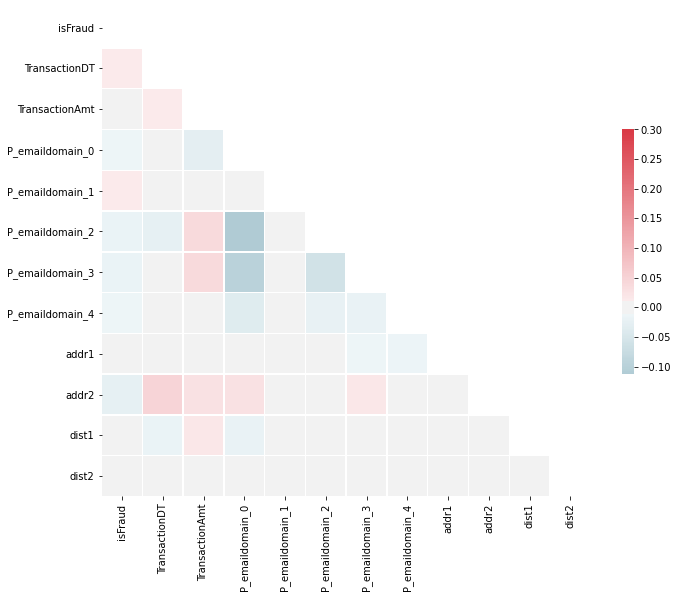

In [20]:
corr = analyzing_data.corr()
mask = np.triu(np.ones_like(corr, dtype=np.bool))
# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

# ***Creat the train/val dataset***

In [21]:
# Create a copy
dataset = copy.copy(dataset_transaction)

# Remove the irrelevant columns
dataset.pop('TransactionID')
dataset.head(5)

,isFraud,TransactionDT,TransactionAmt,card1,card2,card3,card5,addr1,addr2,dist1,dist2,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,D1,D2,D3,D4,D5,D6,D7,D8,D9,D10,D11,D12,D13,D14,D15,...,R_emaildomain_49,R_emaildomain_50,R_emaildomain_51,R_emaildomain_52,R_emaildomain_53,R_emaildomain_54,R_emaildomain_55,R_emaildomain_56,R_emaildomain_57,R_emaildomain_58,R_emaildomain_59,R_emaildomain_60,M1_0,M1_1,M1_2,M2_0,M2_1,M2_2,M3_0,M3_1,M3_2,M4_0,M4_1,M4_2,M4_3,M5_0,M5_1,M5_2,M6_0,M6_1,M6_2,M7_0,M7_1,M7_2,M8_0,M8_1,M8_2,M9_0,M9_1,M9_2
0,0,-0.463379,-0.002083,0.231445,0.000000,-0.024384,-0.418213,0.055145,0.002167,-0.009674,0.0,-0.002794,-0.002508,-0.000217,-0.001817,-0.015961,-0.003582,-0.001264,-0.001544,-0.016571,-0.001609,-0.002584,-0.001279,-0.010811,-0.005104,-0.125488,0.000000,-0.018738,0.000000,0.000000,0.0,0.0,0.0,0.0,-0.126709,-0.184814,0.0,0.0,0.0,-0.170166,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,1,0,1,0,0,0,0,1,0,1,0,0,1,0,0,1,0
1,0,-0.463379,-0.003321,-0.410645,0.082886,-0.024384,-0.709961,0.077881,0.002167,0.000000,0.0,-0.002794,-0.002508,-0.000217,-0.001817,-0.015961,-0.003582,-0.001264,-0.001544,-0.021332,-0.001609,-0.002899,-0.001279,-0.010811,-0.005104,-0.147461,0.000000,0.000000,-0.141235,0.000000,0.0,0.0,0.0,0.0,-0.141479,0.000000,0.0,0.0,0.0,-0.170166,...,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,1,0,0,0,0,0,1,0,0,1,0,1,0,0,1,0,0,1,0
2,0,-0.463379,-0.002380,-0.301025,0.254883,-0.024384,-0.242920,0.089233,0.002167,0.016388,0.0,-0.002794,-0.002508,-0.000217,-0.001817,-0.015961,-0.003582,-0.001264,-0.001544,-0.016571,-0.001609,-0.002899,-0.001279,-0.010811,-0.005104,-0.147461,0.000000,0.000000,-0.141235,0.000000,0.0,0.0,0.0,0.0,-0.141479,0.232910,0.0,0.0,0.0,0.157227,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,1,1,0,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0
3,0,-0.463379,-0.002663,0.473389,0.408936,-0.024384,-0.600586,0.421143,0.002167,0.000000,0.0,-0.002581,-0.001804,-0.000217,-0.001817,-0.015961,-0.002251,-0.001264,-0.001544,-0.016571,-0.001609,-0.002899,-0.001279,-0.002584,-0.005104,0.027588,-0.089966,-0.034607,-0.046417,-0.051697,0.0,0.0,0.0,0.0,-0.045654,0.000000,0.0,0.0,0.0,-0.054840,...,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,1,0,0,0,0,0,1,1,0,0,0,1,0,0,1,0,0,1,0
4,0,-0.463379,-0.002663,-0.310547,0.302979,-0.024384,-0.709961,0.293701,0.002167,0.000000,0.0,-0.002794,-0.002508,-0.000217,-0.001817,-0.015961,-0.003582,-0.001264,-0.001245,-0.021332,-0.001302,-0.002899,-0.001279,-0.010811,-0.005104,-0.147461,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,...,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,0,0,1,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0


In [22]:
from sklearn.model_selection import train_test_split

Y = dataset['isFraud']
dataset.pop('isFraud')
X = dataset

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2)

print(X_train.shape, Y_train.shape, X_test.shape)

(472432, 918) (472432,) (118108, 918)


Percentage of Fraud: 3.5%


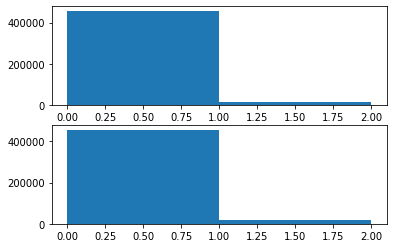

In [23]:
plt.subplot(211)
plt.hist(Y_train, bins=[0,1,2])

plt.subplot(212)
plt.hist(Y_train, bins=[0,1,2])

fraud_count = np.unique(Y_train, return_counts=True)
print("Percentage of Fraud: " + str(round(fraud_count[1][1]/np.sum(fraud_count[1])*100,2)) + "%")

**Downsampling and upsampling**

In [24]:
downsampling_factor = 1
indices_1 = np.argwhere(np.array(Y_train)==1)
indices_0_new = np.argwhere(np.array(Y_train)==0)
indices = np.arange(0,len(indices_0_new),downsampling_factor)
indices_0_new = indices_0_new[indices]

print(indices_0_new.shape)

upsampling_factor = 10
indices_1_new = indices_1
for i in range(upsampling_factor):
  indices_1_new = np.concatenate((indices_1_new, indices_1), axis=0)

indices_0_new = np.concatenate((indices_1_new, indices_0_new), axis=0)

print(indices_0_new.shape)

indices_0_new = tf.random.shuffle(indices_0_new)

X_to_train = np.array(X_train)[indices_0_new]
Y_to_train = np.array(Y_train)[indices_0_new]


X_to_train = np.reshape(X_to_train, (X_to_train.shape[0], X_to_train.shape[2]))
Y_to_train = np.squeeze(Y_to_train, axis=1)
print(X_to_train.shape, Y_to_train.shape)

(455901, 1)
(637742, 1)
(637742, 918) (637742,)


**Check the imbalane of the train/test dataset**

Percentage of Fraud: 28.51%


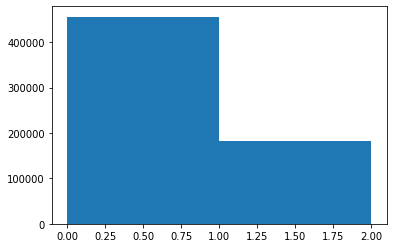

In [25]:
plt.hist(Y_to_train, bins=[0,1,2])

fraud_count = np.unique(Y_to_train, return_counts=True)
print("Percentage of Fraud: " + str(round(fraud_count[1][1]/np.sum(fraud_count[1])*100,2)) + "%")

# ***The model using NN***

In [26]:
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.layers import Dense, Flatten, Dropout, BatchNormalization
from tensorflow.keras import Sequential
from tensorflow.keras.regularizers import l1, l2
from tensorflow.keras.optimizers import Adam, SGD
import tensorflow_addons as tfa
from tensorflow_addons.metrics import F1Score

In [28]:
def create_model(dense1=128, dense2=64, dropout_rate=0.4, l1_rate=0.001, l2_rate=0.001, init_std=0.01, lr=0.001):
  out_model = Sequential()
  out_model.add(Dense(dense1, activation="relu", input_shape=(X_train.shape[1],),
                      kernel_regularizer=tf.keras.regularizers.l1(l1_rate),
                      kernel_initializer=tf.keras.initializers.RandomUniform(minval=-init_std, maxval=init_std),
                      activity_regularizer=tf.keras.regularizers.l2(l2_rate)))
  out_model.add(Dense(dense1, activation="relu",
                      kernel_regularizer=tf.keras.regularizers.l1(l1_rate),
                      kernel_initializer=tf.keras.initializers.RandomUniform(minval=-init_std, maxval=init_std),
                      activity_regularizer=tf.keras.regularizers.l2(l2_rate)))
  out_model.add(Dropout(dropout_rate))
  out_model.add(BatchNormalization())

  out_model.add(Dense(dense2, activation="relu", 
                      kernel_regularizer=tf.keras.regularizers.l1(l1_rate),
                      kernel_initializer=tf.keras.initializers.RandomUniform(minval=-init_std, maxval=init_std),
                      activity_regularizer=tf.keras.regularizers.l2(l2_rate)))
  out_model.add(Dense(dense2, activation="relu",
                      kernel_regularizer=tf.keras.regularizers.l1(l1_rate),
                      kernel_initializer=tf.keras.initializers.RandomUniform(minval=-init_std, maxval=init_std),
                      activity_regularizer=tf.keras.regularizers.l2(l2_rate)))
  out_model.add(Dropout(dropout_rate))
  out_model.add(BatchNormalization())

  out_model.add(Dense(1, activation="sigmoid"))

  out_model.compile(
            optimizer=Adam(learning_rate=lr),
            loss='binary_crossentropy',
            metrics=[tfa.metrics.F1Score(num_classes=2, average="micro", threshold=0.9)])
  
  return out_model

In [29]:
my_model = create_model(dense1=256, dense2=128, dropout_rate=0.4, l1_rate=1e-4, l2_rate=5e-4, init_std=0.05, lr=0.00001)
my_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 256)               235264    
_________________________________________________________________
dense_1 (Dense)              (None, 256)               65792     
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
batch_normalization (BatchNo (None, 256)               1024      
_________________________________________________________________
dense_2 (Dense)              (None, 128)               32896     
_________________________________________________________________
dense_3 (Dense)              (None, 128)               16512     
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0

In [ ]:
BATCH_SIZE = 256
NB_EPOCH = 2000

early_stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_f1_score', patience=200, verbose=0, mode='max',
    baseline=None)

best_model_hold = tf.keras.callbacks.ModelCheckpoint(
    filepath='/content/best_model', monitor='val_f1_score', verbose=1, save_best_only=True,
    save_weights_only=True, mode='max')

history = my_model.fit(X_to_train, Y_to_train, 
             batch_size=BATCH_SIZE, epochs=NB_EPOCH,
             validation_split=0.2, shuffle=True,
             callbacks=[early_stop, best_model_hold])

Epoch 1/2000
1993/1993 [==============================] - ETA: 0s - loss: 1.3917 - f1_score: 0.3593
Epoch 00001: val_f1_score improved from -inf to 0.39749, saving model to /content/best_model
1993/1993 [==============================] - 15s 7ms/step - loss: 1.3917 - f1_score: 0.3593 - val_loss: 1.1701 - val_f1_score: 0.3975
Epoch 2/2000
1989/1993 [============================>.] - ETA: 0s - loss: 1.1224 - f1_score: 0.4257
Epoch 00002: val_f1_score improved from 0.39749 to 0.41427, saving model to /content/best_model
1993/1993 [==============================] - 14s 7ms/step - loss: 1.1222 - f1_score: 0.4257 - val_loss: 1.0316 - val_f1_score: 0.4143
Epoch 3/2000
1992/1993 [============================>.] - ETA: 0s - loss: 1.0049 - f1_score: 0.4322
Epoch 00003: val_f1_score did not improve from 0.41427
1993/1993 [==============================] - 14s 7ms/step - loss: 1.0049 - f1_score: 0.4322 - val_loss: 0.9496 - val_f1_score: 0.4107
Epoch 4/2000
1990/1993 [============================>.

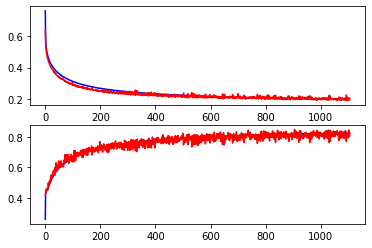

In [39]:
plt.subplot(211)
plt.plot(history.history["loss"], '-b')
plt.plot(history.history["val_loss"], '-r')

plt.subplot(212)
plt.plot(history.history["f1_score"], '-b')
plt.plot(history.history["val_f1_score"], '-r')



**F1 validation (From https://datascience.stackexchange.com/questions/45165/how-to-get-accuracy-f1-precision-and-recall-for-a-keras-model)**

In [30]:
# Save model weights to drive
#!cp best_model* '/content/gdrive/My Drive/Kaggle'

new_model = create_model(dense1=128, dense2=64, dropout_rate=0.4, l1_rate=0, l2_rate=0, init_std=0.05, lr=0.00005)
new_model.load_weights('/content/gdrive/My Drive/Kaggle/best_model')

new_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 128)               115712    
_________________________________________________________________
dense_1 (Dense)              (None, 128)               16512     
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
batch_normalization (BatchNo (None, 128)               512       
_________________________________________________________________
dense_2 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_3 (Dense)              (None, 64)                4160      
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0

In [33]:
def precision_cal(y_pred, y_ref):
  pre = 0
  if np.any(y_pred == 1):
    indices_positive = np.argwhere(y_pred == 1)
    true_pos = np.sum(y_ref[indices_positive])

    if true_pos == len(indices_positive):
      false_pos = 0
    else:
      false_pos = len(indices_positive) - true_pos

    pre = true_pos/(true_pos + false_pos)
  return pre

def recall_cal(y_pred, y_ref):
  recall = 0
  if np.any(y_pred == 1):
    indices_positive = np.argwhere(y_pred == 1)
    true_pos = np.sum(y_ref[indices_positive])

    fals_neg = np.sum(y_ref[np.argwhere(y_pred == 0)])
       
    recall = true_pos/(true_pos + fals_neg)

  return recall

def F1_score(model, X_test, y_ref, test_size, threshold=0.5):
  test_size = len(Y_test)
  y_pred = (model.predict(X_test[:test_size], batch_size=128)>threshold).astype(int)
  y_pred = np.squeeze(y_pred, axis=1)
  y_pred[7] = 1
  y_pred[23] = 1
  #pred_dist = np.unique(y_pred.astype(int), return_counts=True)
  #correct_prediction = np.unique(y_pred == np.expand_dims(Y_test[:test_size], axis=1), return_counts=True)
  #print(pred_dist, correct_prediction[0])
  
  precision = precision_cal(y_pred, np.array(Y_test[:test_size]))
  recall = recall_cal(y_pred, np.array(Y_test[:test_size]))

  return precision, recall, 2*precision*recall/(precision+recall)

pre, re, f1 = F1_score(new_model, X_test, Y_test, test_size=len(Y_test), threshold=0.9)
print(pre, re, f1)

0.8491379310344828 0.7181044957472661 0.7781435154707045


In [27]:
new_model.evaluate(X_test, Y_test)
prediction = new_model.predict(X_test)

3691/3691 [==============================] - 15s 4ms/step - loss: 0.0712 - f1_score: 0.7901


In [33]:
try:
  new_model.evaluate(X_train, Y_train, batch_size=BATCH_SIZE)
except NameError:
  BATCH_SIZE = 256
  new_model.evaluate(X_train, Y_train, batch_size=BATCH_SIZE)

1846/1846 [==============================] - 8s 4ms/step - loss: 0.0697 - f1_score: 0.7809


Percentage of Fraud: 3.08% 3.54%


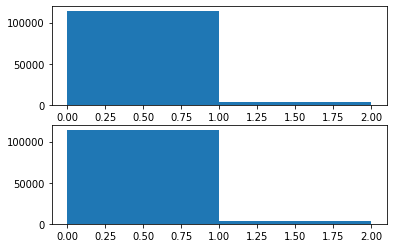

In [36]:
prediction = np.squeeze(prediction, axis=1)

plt.subplot(211)
plt.hist(Y_test, bins=[0,1,2])

plt.subplot(212)
plt.hist((prediction>0.9).astype('int'), bins=[0,1,2])



fraud_predict = np.unique((prediction>0.9).astype('int'), return_counts=True)
fraud_real = np.unique(Y_test, return_counts=True)
print("Percentage of Fraud: " + str(round(fraud_predict[1][1]/np.sum(fraud_predict[1])*100,2)) + "% " + str(round(fraud_real[1][1]/np.sum(fraud_real[1])*100,2)) + "%")



In [ ]:
fraud_count

(array([0, 1]), array([65115, 33254]))

# ***Output the result into a file for a validation with Kaggle***

In [7]:
os.chdir("/content")
test_transaction = pd.read_csv('test_transaction.csv')
test_transaction.head(5)

,TransactionID,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,addr1,addr2,dist1,dist2,P_emaildomain,R_emaildomain,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,D1,D2,D3,D4,D5,D6,D7,D8,D9,D10,...,V300,V301,V302,V303,V304,V305,V306,V307,V308,V309,V310,V311,V312,V313,V314,V315,V316,V317,V318,V319,V320,V321,V322,V323,V324,V325,V326,V327,V328,V329,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339
0,3663549,18403224,31.95,W,10409,111.0,150.0,visa,226.0,debit,170.0,87.0,1.0,NaN,gmail.com,NaN,6.0,6.0,0.0,0.0,3.0,4.0,0.0,0.0,6.0,0.0,5.0,1.0,115.0,6.0,419.0,419.0,27.0,398.0,27.0,NaN,NaN,NaN,NaN,418.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.000000,47.950001,0.000000,0.000000,47.950001,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,3663550,18403263,49.00,W,4272,111.0,150.0,visa,226.0,debit,299.0,87.0,4.0,NaN,aol.com,NaN,3.0,2.0,0.0,0.0,0.0,1.0,0.0,0.0,2.0,0.0,1.0,1.0,12.0,2.0,149.0,149.0,7.0,634.0,7.0,NaN,NaN,NaN,NaN,231.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.000000,280.000000,77.000000,0.000000,280.000000,0.000000,77.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3663551,18403310,171.00,W,4476,574.0,150.0,visa,226.0,debit,472.0,87.0,2635.0,NaN,hotmail.com,NaN,2.0,2.0,0.0,0.0,0.0,5.0,0.0,0.0,4.0,0.0,2.0,0.0,22.0,2.0,137.0,137.0,10.0,97.0,10.0,NaN,NaN,NaN,NaN,136.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.000000,1321.000000,0.000000,0.000000,1058.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,263.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3663552,18403310,284.95,W,10989,360.0,150.0,visa,166.0,debit,205.0,87.0,17.0,NaN,gmail.com,NaN,5.0,2.0,0.0,0.0,1.0,1.0,0.0,0.0,2.0,0.0,2.0,0.0,7.0,4.0,42.0,42.0,41.0,242.0,41.0,NaN,NaN,NaN,NaN,242.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,282.540009,282.540009,282.540009,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,3663553,18403317,67.95,W,18018,452.0,150.0,mastercard,117.0,debit,264.0,87.0,6.0,NaN,gmail.com,NaN,6.0,6.0,0.0,0.0,2.0,5.0,0.0,0.0,5.0,0.0,6.0,0.0,14.0,6.0,22.0,22.0,0.0,22.0,0.0,NaN,NaN,NaN,NaN,22.0,...,0.0,0.0,0.0,0.0,0.0,1.0,67.949997,183.850006,67.949997,67.949997,183.850006,67.949997,67.949997,67.949997,183.850006,67.949997,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [8]:
float_columns_test = test_transaction.columns[np.where(test_transaction.dtypes == np.dtype('float64'))].to_list()
int_columns_test = test_transaction.columns[np.where(test_transaction.dtypes == np.dtype('int64'))].to_list()
obj_columns_test = test_transaction.columns[np.where(test_transaction.dtypes == np.dtype('O'))].to_list()

skip_int_columns = ['TransactionID']
for column in skip_int_columns:
  int_columns_test.remove(column)

skip_obj_colums = ['']

In [49]:
def apply_normalization(X, indices, cache_min, cache_max, cache_mean):
  X_out = copy.copy(X)
  #print(cache_mean, cache_max, cache_min)
  X_out[indices] = (X_out[indices] - cache_mean)/(cache_max - cache_min)
  X_out[np.where(np.isnan(X_out))[0]] = 0
  return X_out.astype('float16')  


In [50]:
for column in float_columns:
  # Set to float 16
  test_transaction[column].astype('float16')

  # Code the NaN feature
  test_transaction[column + "_NaN_Code"] = np.isnan(test_transaction[column].values).astype('int8')
  
  # Normalization
  X = test_transaction[column]
  indices = np.where(np.isnan(test_transaction[column]) == False)[0]
  test_transaction[column] = apply_normalization(X.to_numpy(), indices, cache[column+'_min'], cache[column+'_max'], cache[column+'_mean'])

In [51]:
for column in int_columns:
  # Set to int 32
  test_transaction[column].astype('int32')

  # Code the NaN feature
  if np.any(np.isnan(test_transaction[column].values)):
    test_transaction[column + "_NaN_Code"] = np.isnan(test_transaction[column].values).astype('int8')
  
  # Normalization
  X = test_transaction[column]
  indices = np.where(np.isnan(test_transaction[column]) == False)[0]
  test_transaction[column] = apply_normalization(X.to_numpy(), indices, cache[column+'_min'], cache[column+'_max'], cache[column+'_mean'])

In [9]:
encoded_column = 0
for column in obj_columns_test:
  ohc = OneHotEncoder(handle_unknown='ignore')
  ohc.fit(cache[column])
  test_transaction.loc[np.where(test_transaction[column].isnull())[0], column] = 'Null'
  encoded = ohc.transform(test_transaction[column].values.reshape(-1,1)).toarray()    
  pd_encoded = pd.DataFrame(encoded.astype('int8'), columns=[column+"_"+str(i) for i in range(len(np.unique(cache[column])))])
  test_transaction = pd.concat([test_transaction, pd_encoded], axis=1)
  encoded_column += len(pd_encoded.columns)

print("Encoded columns: " + str(encoded_column))


for column in obj_columns_test:
  try:
    test_transaction.pop(column)
  except KeyError:
    pass

Encoded columns: 164


In [46]:
# Check if we have the same shape with the X_train
print(test_transaction.shape, X_train.shape)

NameError: ignored

In [ ]:
# Make the prediction and submit the output
result = new_model.predict(test_transaction)
kaggle competitions submit -c ieee-fraud-detection -f submission.csv -m "Message"

# ***Debug zone***

In [ ]:
indices = np.where(np.isnan(a) == False)[0]
min_value, max_value, mean_value, normalized_data = normalization_data(a, indices)
print(min_value, max_value, mean_value, np.mean(normalized_data), np.min(normalized_data), np.max(normalized_data))
dataset_transaction['V331'] = normalized_data

0.0 160000.0 721.7418829164045 -2.2733716828843707e-16 -0.004510886768227528 0.9954891132317726


In [ ]:
from sklearn.preprocessing import OneHotEncoder
ohc = OneHotEncoder()
a = {'a': ['Null', 'A', 'B', 'C', 'D']}
df = pd.DataFrame(a)
df
encoded = ohc.fit_transform(df['a'].values.reshape(-1,1)).toarray()    
pd_encoded = pd.DataFrame(encoded.astype('int8'), columns=["a"+"_"+str(i) for i in range(len(np.unique(df['a'].astype('str'))))])
pd_encoded


,a_0,a_1,a_2,a_3,a_4
0,0,0,0,0,1
1,1,0,0,0,0
2,0,1,0,0,0
3,0,0,1,0,0
4,0,0,0,1,0


In [ ]:
b = {'a': ['Null', 'A', 'B', 'C', 'E']}
df_b = pd.DataFrame(b)
ohc_b = OneHotEncoder(handle_unknown='ignore')
ohc_b.fit(df['a'].values.reshape(-1,1))
encoded_b = ohc_b.transform(df_b['a'].values.reshape(-1,1)).toarray()    
pd_encoded_b = pd.DataFrame(encoded_b.astype('int8'), columns=["a"+"_"+str(i) for i in range(len(np.unique(df['a'].astype('str'))))])
pd_encoded_b

,a_0,a_1,a_2,a_3,a_4
0,0,0,0,0,1
1,1,0,0,0,0
2,0,1,0,0,0
3,0,0,1,0,0
4,0,0,0,0,0


In [ ]:
for column in obj_columns:
  dataset_transaction.loc[np.where(dataset_transaction[column].isnull())[0], column] = 'Null'
  print(column, len(np.unique(dataset_transaction[column].astype("str"))))

ProductCD 5
card4 5
card6 5
P_emaildomain 60
R_emaildomain 61
M1 3
M2 3
M3 3
M4 4
M5 3
M6 3
M7 3
M8 3
M9 3


In [ ]:
for column in obj_columns_test:
  test_transaction.loc[np.where(test_transaction[column].isnull())[0], column] = 'Null'
  print(column, len(np.unique(test_transaction[column].astype("str"))))

ProductCD 5
card4 5
card6 4
P_emaildomain 61
R_emaildomain 61
M1 3
M2 3
M3 3
M4 4
M5 3
M6 3
M7 3
M8 3
M9 3


**Train val dataset**